# Anomaly Detection in ECG data

This notebook provides tasks to identify anomalies in an ECG data set. Download the dataset from the lab google drive.

Required Python packages: pandas, numpy, matplotlib, pytorch

## Task 1: Load an visualize the data

Download the csv from the link provided above and load it into a pandas dataframe. Visualize the data of normal (label 1) vs abnormal (label 0) ECG signals. 

What are the differences for both? Visualize an average normal and abnormal ECG (with standart derivations).

In [48]:
import pandas as pd

dataframe = pd.read_csv(
    "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None
)
raw_data = dataframe.values

In [57]:
label = raw_data[:,-1]
normal_data = raw_data[label == 0][:,:-1]
anomaly_data = raw_data[label == 1][:,:-1]
print(raw_data.shape, normal_data.shape, anomaly_data.shape, label.shape)

(4998, 141) (2079, 140) (2919, 140) (4998,)


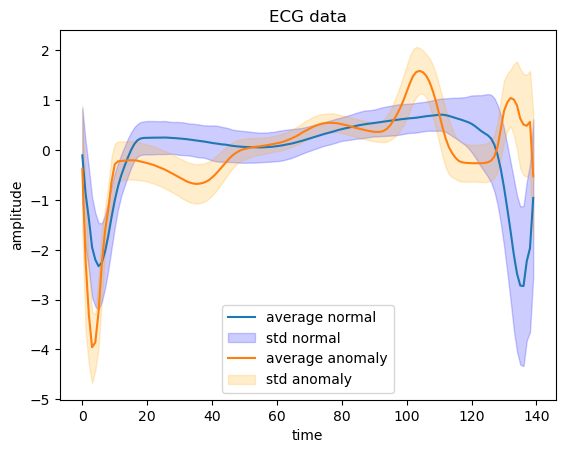

In [76]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.mean(normal_data, axis=0), label="average normal")
plt.fill_between(x = range(len(np.mean(normal_data, axis=0))), 
                 y1 = np.mean(normal_data, axis=0) + np.std(normal_data, axis=0), 
                 y2 = np.mean(normal_data, axis=0) - np.std(normal_data, axis=0), 
                 alpha=0.2,
                 color="blue",
                 label="std normal")
plt.plot(np.mean(anomaly_data, axis=0), label="average anomaly")
plt.fill_between(x = range(len(np.mean(anomaly_data, axis=0))), 
                 y1 = np.mean(anomaly_data, axis=0) + np.std(anomaly_data, axis=0), 
                 y2 = np.mean(anomaly_data, axis=0) - np.std(anomaly_data, axis=0), 
                 alpha=0.2,
                 color="orange",
                 label="std anomaly")
plt.title("ECG data")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.legend()
plt.show()

## Task 2: Train a Autoencoder for normal (training data)

Split your data into a (stratified) 80/20 split. Use the normal records of your train data to fit an Autoencoder model. You may use Optuna to find the optimal parametrization of your model.

Visulaize the training/test loss of your model.


In [106]:
import optuna
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Preprocess Data

In [104]:
labels = raw_data[:,-1]
scaler = MinMaxScaler()
data = scaler.fit_transform(raw_data)
train, test = train_test_split(data, test_size=0.2, stratify=labels, random_state=42)

In [105]:
# Verify the split
print(f"Mean train label: {np.mean(train[:,-1])}, Mean test label: {np.mean(test[:,-1])}")

Mean train label: 0.5840420210105053, Mean test label: 0.584


## Write Dataset and Dataloader

In [138]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class ECGDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # For autoencoder, input = target

## Autoencoder model

In [118]:
train_tensor = torch.from_numpy(train).float()

In [135]:
class AE(nn.Module):
    def __init__(self, input_dim=139):
        super(AE, self).__init__()
        # Define the architecture
        # The Encoder part has to compress the input data (139) to a latent space representation (16)
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        # The Decoder part has to reconstruct the input data (139) from the latent space representation (16)
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid(),  # Use Sigmoid to ensure output is between 0 and 1
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out

In [136]:
ae_model = AE(input_dim=train.shape[1])

In [137]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)

## Task 3: Treshold your test data & evaluate your model

For any single normal and abnormal test data point, plot the time series, the decoded autoencoder reconstruction and the error as the area between these 2 plots. Compute the absolute error as the absolute of the integral of both graphs.

Plot a histogram of the training/test loss and - based on your findings - generate a treshold to differentiate between normal/anormal test data samples. Based on your predictions, report the performance of your model. 


